# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Lindsey Conboy

**ID**: 5140123

> **Due Date**
>
> Friday, 09/22/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\15183\Desktop\BEE 4750\HW2\hw02-llc223`

In [2]:
using Plots
using LaTeXStrings
using Distributions

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.55 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [20]:
#Initial Values
QR = 100000; #River Inflow L/d 
QW1 = 10000; #Waste Stream 1 Inflow L/d
QW2 = 15000; #Waste Stream 2 Inflow L/d
DOR = 7.5; #DO River mg/L
DOW1 = 5; #DO Waste Stream 1 mg/L 
DOW2 = 5; #DO Waste Stream 2 mg/L 
CBODR = 5; #CBOD River mg/L 
CBODW1 = 50; #CBOD Waste Stream 1 mg/L 
CBODW2 = 45; #CBOD Waste Stream 2 mg/L 
NBODR = 5; #NBOD River mg/L 
NBODW1 = 35; #NBOD Waste Stream 1 mg/L 
NBODW2 = 35; #NBOD Waste Stream 2 mg/L 
Cs = 10; #Saturated Dissolved Oxygen Concentration mg/L
ka = .55; #Oxygen Reaeration Rate /d 
kc = .35; #CBOD decay rate /d
kn = .25; #NBOD decay rate /d
U = 6; #River Velocity km/D

#Calculate Initial DO, CBOD, NBOD Mixed Concentrations
C0 = ((DOR*QR)+(DOW1*QW1))/(QR+QW1); #Initial Mixed DO Conc. mg/L
B0 = ((CBODR*QR)+(CBODW1*QW1))/(QR+QW1); #Initial Mixed CBOD Conc. mg/L
N0 = ((NBODR*QR)+(NBODW1*QW1))/(QR+QW1); #Initial Mixed NBOD Conc. mg/L

#Define the functions to find DO, NBOD, CBOD

function dissolved_oxygen(x, Cs, C0, B0, N0, ka, kc, kn, U)
    α1 = exp(-ka * x / U)
    α2 = (kc / (ka - kc)) * (exp(-kc * x / U) - α1)
    α3 = (kn / (ka - kn)) * (exp(-kn * x / U) - α1)
    C = (Cs * (1 - α1)) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return C
end

function NBOD(x, Cs, C0, B0, N0, ka, kc, kn, U)
    α1 = exp(-ka * x / U)
    α3 = (kn / (ka - kn)) * (exp(-kn * x / U) - α1)
    NBODx = (N0 * α3);
    return NBODx
end

function CBOD(x, Cs, C0, B0, N0, ka, kc, kn, U)
    α1 = exp(-ka * x / U)
    α2 = (kc / (ka - kc)) * (exp(-kc * x / U) - α1)
    CBODx = (B0 * α2);
    return CBODx
end

#Run the function from waste stream 1 entrance to before waste stream 2
x = 0:0.1:15; #From 0km to 15km downstream
C = (y -> dissolved_oxygen(y, Cs, C0, B0, N0, ka, kc, kn, U)).(x);
NBOD1 = NBOD(15, Cs, C0, B0, N0, ka, kc, kn, U); #NBOD at 15km before WS2 mix
CBOD1 = CBOD(15, Cs, C0, B0, N0, ka, kc, kn, U); #CBOD at 15km before WS2 mix
C1 = dissolved_oxygen(15, Cs, C0, B0, N0, ka, kc, kn, U); #DO at 15km before WS2 mix

#Calculate DO, CBOD, NBOD Mixed Concentrations at Waste Stream 2 Mixing
C2 = ((C1*(QR+QW1))+(DOW2*QW2))/(QR+QW1+QW2); #Initial Mixed DO Conc. mg/L
B2 = ((CBOD1*(QR+QW1))+(CBODW2*QW2))/(QR+QW1+QW2); #Initial Mixed CBOD Conc. mg/L
N2 = ((NBOD1*(QR+QW1))+(NBODW2*QW2))/(QR+QW1+QW2); #Initial Mixed NBOD Conc. mg/L

#Run the function from waste stream 2 entrance to 50km
x2 = 0:0.1:35; #From 0km to 15km downstream
C2 = (y -> dissolved_oxygen(y, Cs, C0, B0, N0, ka, kc, kn, U)).(x2)
x3 = 0:0.1:50;

C3 = zeros(501)

for i in 1:1:151
    C3[i]=C2[i]
end

j = 1
for i in 151:501
    C3[i] = C2[j]
    j = j + 1;
end

display(C3)

#Find the minimum DO Conc.
minimum = 10
for i in 1:1:501
    if C3[i] < minimum
        minimum = C3[i]
        x = i
    end
end
dist = x*.1-.1
display(minimum)
display(dist)

501-element Vector{Float64}:
 7.2727272727272725
 7.212995880379152
 7.1542486478520955
 7.096474261340855
 7.039661522932008
 6.983799349476664
 6.9288767714738695
 6.874882931964561
 6.821807085436017
 6.769638596736685
 ⋮
 7.140935567730455
 7.152172750390484
 7.1633810193745004
 7.174560263336307
 7.185710373907333
 7.196831245658973
 7.207922776065319
 7.218984865466306
 7.23001741703124

4.71162276252984

10.9

4.71162276252984

The minimum dissolved oxygen concentration is ~4.712 mg/L. This concentration occurs at 10.9 km downstream.

### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

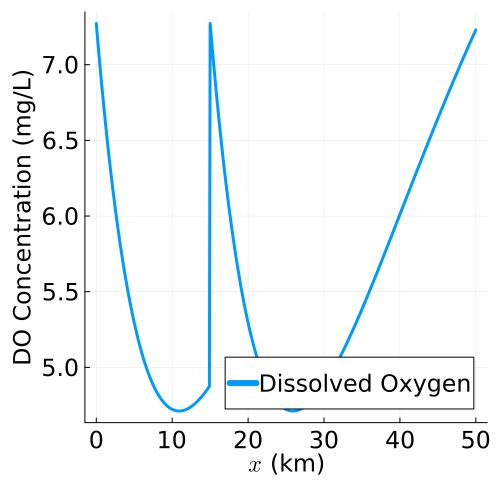

In [13]:
plot(x3, C3; linewidth=3, 
    label="Dissolved Oxygen", 
    tickfontsize=16, 
    guidefontsize=16, 
    legendfontsize=16)
xlabel!(L"$x$ (km)")
ylabel!("DO Concentration (mg/L)")
plot!(size=(500, 500))





The dissolved oxygen concentration has two large decreases followed by increases in level. Each decrease begins after one of the waste streams enters the river. After the second waste stream enters the river, the DO Concentration has a sharp increase followed by a sharp decrease, creating an overall 'w' shape of the graph.

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [24]:
#The graph above shows that the river reaches 6mg/L DO between 30 and 50 km, so I will find the exact distance downstream from vector C3
i = 300
while C3[i] < 6
    i = i + 1
end

dist6 = i*.1-.1
display(dist6)



40.0

The river recovers to a dissolved oxygen concentration of 6mg/L at 40km downstream, which is 25km downstream from waste stream 2.

### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

## References

List any external references consulted, including classmates.